In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import matplotlib.dates as mdates
import datetime as dt

In [2]:
def rolling_z_score(column, window_size):
    # Calculate the rolling mean and standard deviation
    rolling_mean = column.rolling(window=window_size).mean()
    rolling_std = column.rolling(window=window_size).std()
    # Calculate the z-score using the formula
    z_score = (column - rolling_mean) / rolling_std
    return z_score

In [3]:
def adf_test(series):
    result = adfuller(series)
    print('Augmented Dicky Fuller Test')
    labels = ['Test Statistic','p-value','Lag Used']
    output = list(result[:3]) + [result[-2]['5%'], result[-2]['1%']]
    for value, label in zip(output,labels):
        print(label+': '+str(round(value, 7)))
        
    if result[1] <= .05:
      print('Series is likely stationary')
    else:
       print('Series is likely non-stationary')

In [4]:
def extract_significant_granger_causality(data, max_lag=5, significance_level=0.05):
    results = grangercausalitytests(data, max_lag, verbose=False)
    significant_results = {}
    for lag in results.keys():
        p_value = results[lag][0]['ssr_ftest'][1]
        if p_value < significance_level:
            significant_results[lag] = p_value
    return significant_results

In [5]:
def extract_p_value(data, max_lag=5):
    results = grangercausalitytests(data, max_lag, verbose=False)
    significant_results = {}
    p_value = {}
    for lag in results.keys():
        p_value[lag]=results[lag][0]['ssr_ftest'][1]
    return p_value

In [6]:
def plot_sentiment_price(data1, data2, data3, data4, model : str, crypto:str, filetype:str):
    fig, ax1 = plt.subplots()

    color = 'red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('Activity Count', color='black')
    ax1.plot(data1.index, data2, color=color, label=f'Negative {filetype}s')
    ax1.tick_params(axis='y', labelcolor='black')

    color = 'pink'
    ax1.plot(data1.index, data3, color=color, label=f'Total {filetype}s')

    color = 'green'
    ax1.plot(data1.index, data4, color=color, label=f'Positive {filetype}s')

    # color = 'orange'
    # ax1.plot(ts_prices_btc.index, data5, color=color, label='Negative Comments')

    # color = 'purple'
    # ax1.plot(ts_prices.index, data6, color=color, label='Neutral Comments')

    # color = 'brown'
    # ax1.plot(ts_prices.index, data7, color=color, label='Neutral Comments')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('Price (Log-Scale)', color='black')  # we already handled the x-label with ax1
    ax2.plot(data1.index, data1, color=color, label=f'{crypto} Closing Price (USD)')
    ax2.tick_params(axis='y', labelcolor='black')
    ax1.tick_params(axis='x', labelrotation=90)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3)
    ax1.set_xlabel('Date', color='black') 

    plt.title(f'Sampled Reddit Activity and Closing {crypto} Price (Sentiment analysed using {model})')
    # plt.xticks(ts_pos_sub.index)
    plt.grid()
    plt.show()

## Bitcoin

In [6]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin.csv",index_col='date',parse_dates=['date'])

<AxesSubplot:xlabel='date'>

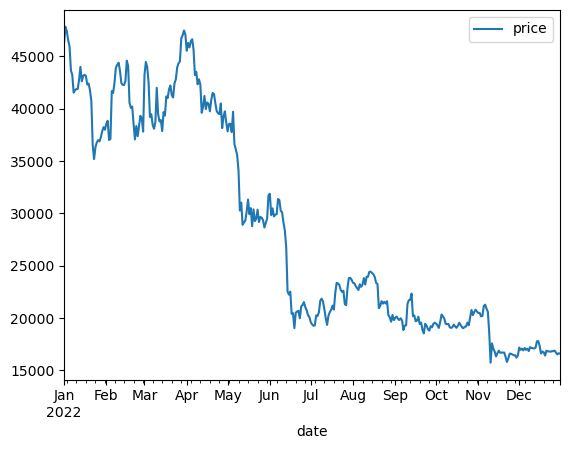

In [7]:
ts_prices_btc.plot()

In [8]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [13]:
for model in ['CRYPTOBERT','VADER']:
    for filetype in ['submission','comment']:
        print(f"{model}_{filetype}_sentiment")
        df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_{filetype}_sentiment.csv",index_col='posted_on',parse_dates=['posted_on'])
        # print(df.columns)
        for col in df.columns[:3]:
            ts_prices_btc[f"{model}_{filetype}_{col}_prop"] = df[col]/df['total_posts']
            ts_prices_btc[f"{model}_{filetype}_{col}"] = df[col]
        ts_prices_btc[f"total_{filetype}"] = df['total_posts']

CRYPTOBERT_submission_sentiment
CRYPTOBERT_comment_sentiment
VADER_submission_sentiment
VADER_comment_sentiment


In [15]:
# Remove Neautral Time Series
for c in ts_prices_btc.columns:
    if 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column CRYPTOBERT_submission_Neutral_prop
Dropping column CRYPTOBERT_submission_Neutral
Dropping column CRYPTOBERT_comment_Neutral_prop
Dropping column CRYPTOBERT_comment_Neutral
Dropping column VADER_submission_Neutral_prop
Dropping column VADER_submission_Neutral
Dropping column VADER_comment_Neutral_prop
Dropping column VADER_comment_Neutral


In [17]:
btc_z_transformed = pd.DataFrame()
for col in ts_prices_btc.columns:
    btc_z_transformed[col] = rolling_z_score(ts_prices_btc[col],window_size=3)
btc_z_transformed.dropna(inplace=True)
btc_z_transformed.head(5)

,price,CRYPTOBERT_submission_Negative_prop,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive_prop,CRYPTOBERT_submission_Positive,CRYPTOBERT_comment_Negative_prop,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive_prop,CRYPTOBERT_comment_Positive,total_comment,VADER_submission_Negative_prop,VADER_submission_Negative,VADER_submission_Positive_prop,VADER_submission_Positive,VADER_comment_Negative_prop,VADER_comment_Negative,VADER_comment_Positive_prop,VADER_comment_Positive,total_submission
date,,,,,,,,,,,,,,,,,,,
2022-01-03,0.276275,-0.746529,-0.577350,0.354668,0.927173,1.152346,0.320256,-0.973508,-1.103404,-0.577350,1.038633,1.154701,0.942036,1.141822,1.071234,0.934261,1.150884,0.965060,1.152498
2022-01-04,-1.090907,1.099064,1.154701,-0.262641,-0.463967,-1.115489,-1.153846,-0.927250,-1.026784,-1.112634,-1.124281,-0.872872,-0.670621,-0.642543,-0.410433,-1.072222,1.014397,-0.955847,-0.637990
2022-01-05,-0.934405,0.686483,1.091089,-0.788212,0.060523,-0.822802,1.014173,1.084719,1.134269,1.136784,-0.992941,-0.414781,0.406682,0.761220,-0.730505,1.072222,-1.000058,1.148295,0.891390
2022-01-06,-1.132598,-1.050702,0.577350,1.012891,1.059626,1.148089,1.047749,0.497622,0.565128,0.593166,1.120367,1.153437,-0.915930,0.267067,1.147035,0.866947,-0.825793,0.392430,0.884992
2022-01-07,-0.718265,1.146608,1.154701,-0.258250,-0.286998,-0.114488,-0.563440,-1.053204,-1.154103,-1.153810,0.449142,0.286998,-0.434638,-0.832050,1.065092,0.700778,0.615520,-1.076430,-0.270073


price


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


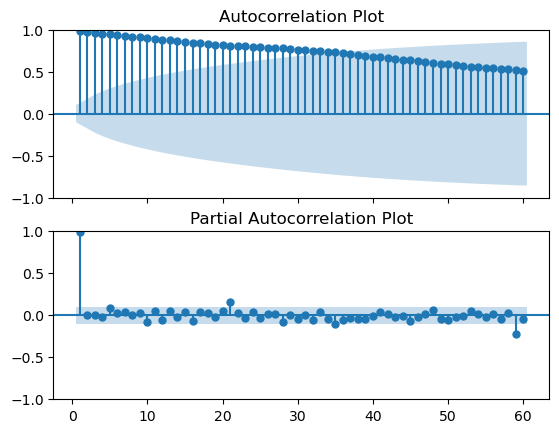

Augmented Dicky Fuller Test
Test Statistic: -12.1625014
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


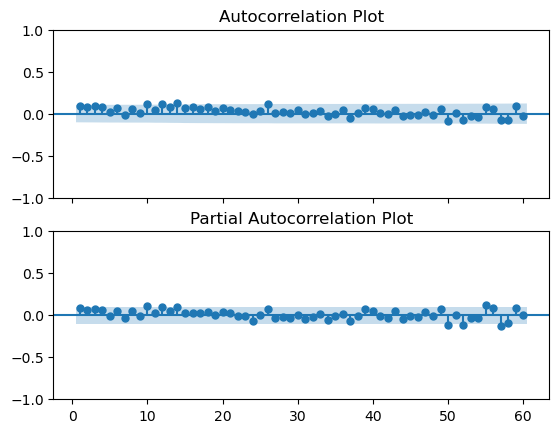

Augmented Dicky Fuller Test
Test Statistic: -14.6379336
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


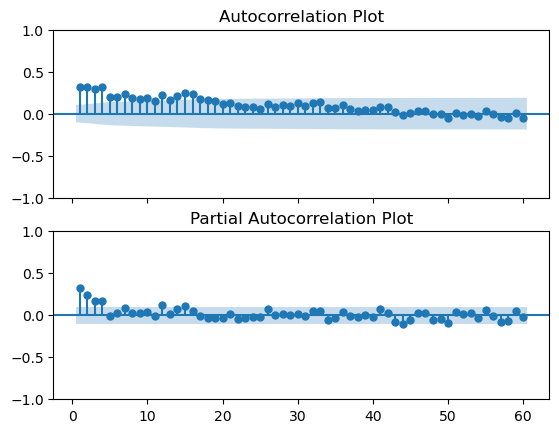

Augmented Dicky Fuller Test
Test Statistic: -19.5532404
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


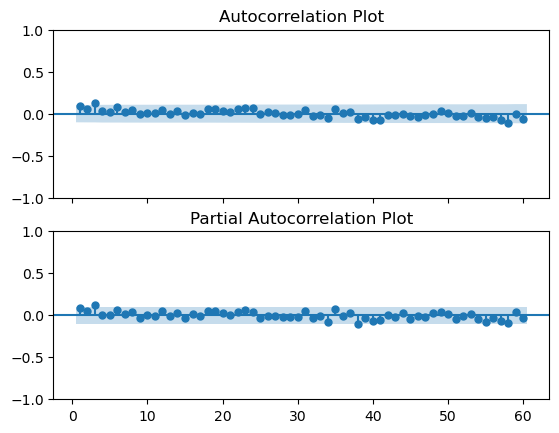

Augmented Dicky Fuller Test
Test Statistic: -12.1768083
p-value: 0.0
Lag Used: 3
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


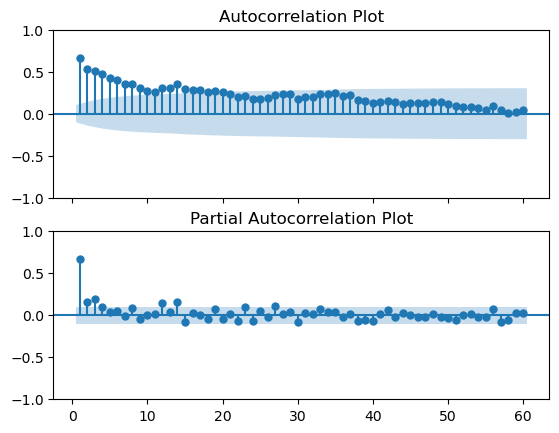

Augmented Dicky Fuller Test
Test Statistic: -11.1712896
p-value: 0.0
Lag Used: 4
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


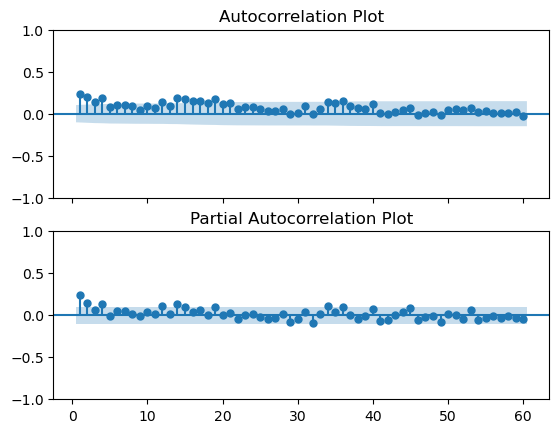

Augmented Dicky Fuller Test
Test Statistic: -4.2953218
p-value: 0.0004526
Lag Used: 15
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


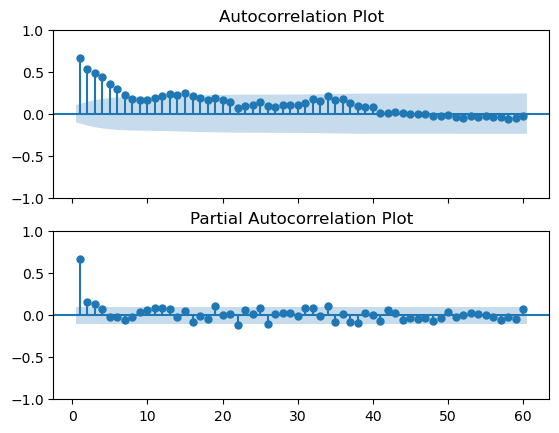

Augmented Dicky Fuller Test
Test Statistic: -18.6017111
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


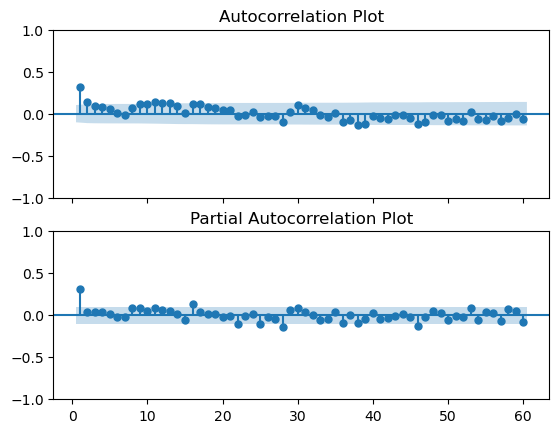

Augmented Dicky Fuller Test
Test Statistic: -12.5641391
p-value: 0.0
Lag Used: 3
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


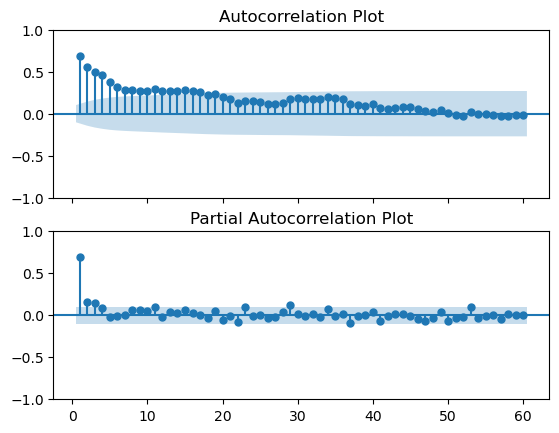

Augmented Dicky Fuller Test
Test Statistic: -18.9904214
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
total_comment


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


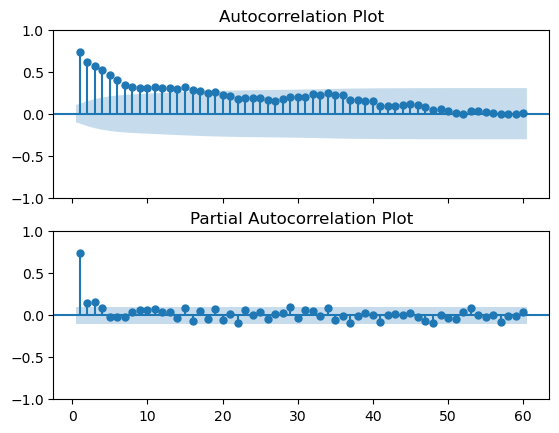

Augmented Dicky Fuller Test
Test Statistic: -18.2962422
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


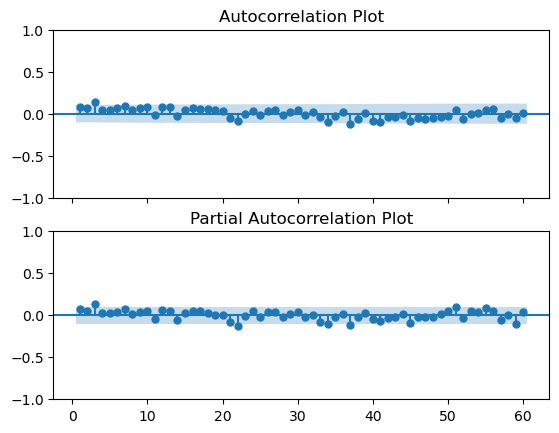

Augmented Dicky Fuller Test
Test Statistic: -19.3150589
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


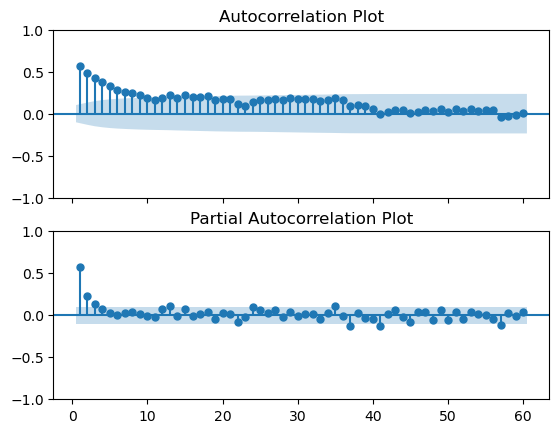

Augmented Dicky Fuller Test
Test Statistic: -19.2886136
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


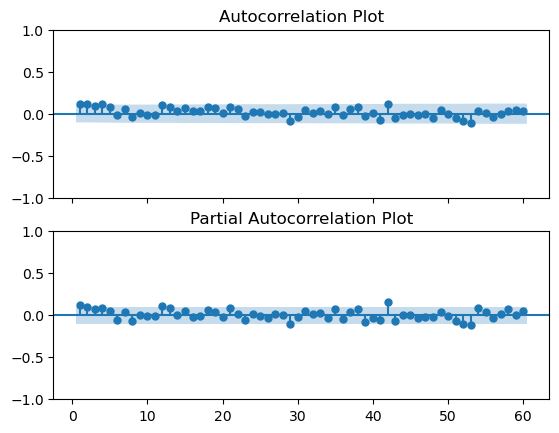

Augmented Dicky Fuller Test
Test Statistic: -16.9470912
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


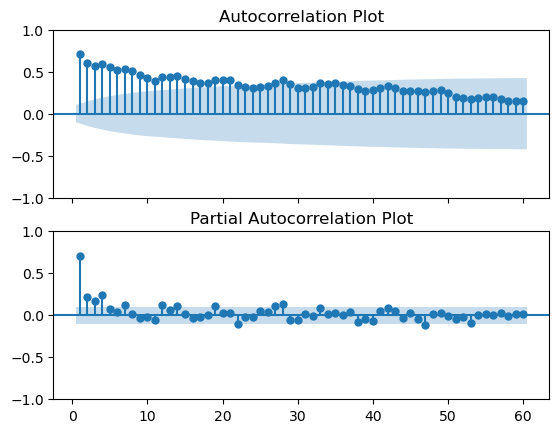

Augmented Dicky Fuller Test
Test Statistic: -6.2066266
p-value: 1e-07
Lag Used: 10
Series is likely stationary
****************************************************************************************************
VADER_comment_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


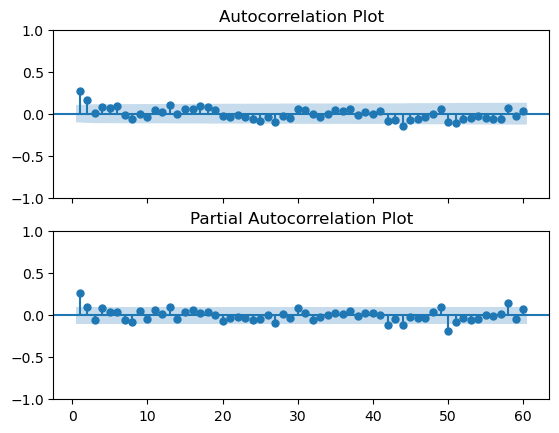

Augmented Dicky Fuller Test
Test Statistic: -11.8030551
p-value: 0.0
Lag Used: 3
Series is likely stationary
****************************************************************************************************
VADER_comment_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


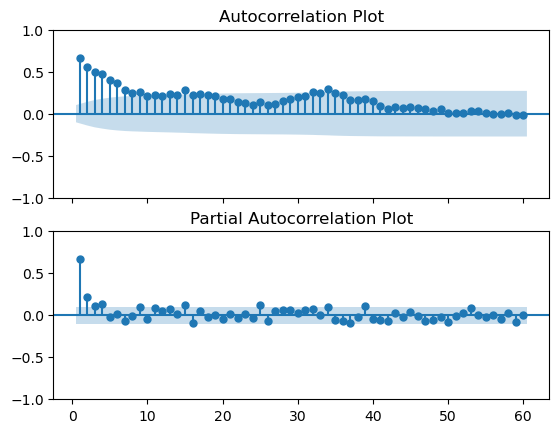

Augmented Dicky Fuller Test
Test Statistic: -13.8834383
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
VADER_comment_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


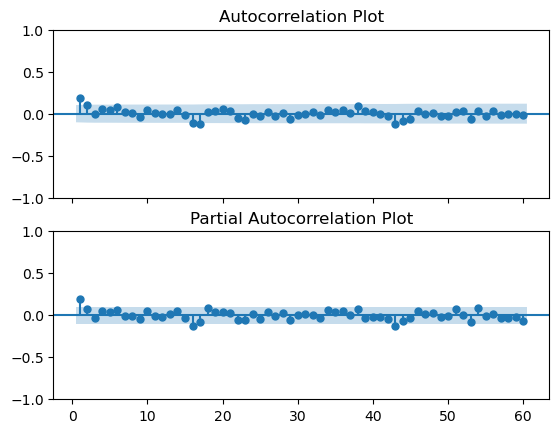

Augmented Dicky Fuller Test
Test Statistic: -10.92423
p-value: 0.0
Lag Used: 4
Series is likely stationary
****************************************************************************************************
VADER_comment_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


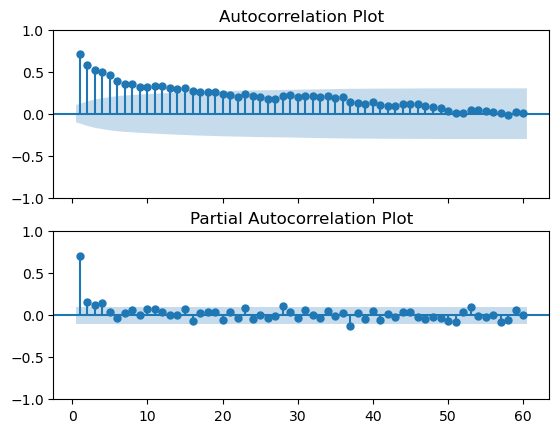

Augmented Dicky Fuller Test
Test Statistic: -13.569911
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
total_submission


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


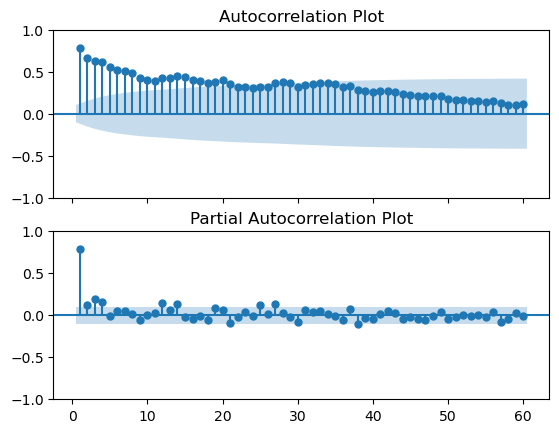

Augmented Dicky Fuller Test
Test Statistic: -8.1075678
p-value: 0.0
Lag Used: 10
Series is likely stationary
****************************************************************************************************


In [18]:
# Checking for Stationarity
for i in range(0,len(btc_z_transformed.columns)):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    ax1, ax2 = axes.flatten()
    print(btc_z_transformed.columns[i])
    plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    plt.show()
    adf_test(btc_z_transformed.iloc[:,i])
    print("*"*100)

Hence, all the time series are now stationary

In [19]:
columns = [] 
for col in ts_prices_btc.columns[1:]:
    for i in range(1,15):
        columns.append(f'{col}_{i}_lag')
print(columns)
gc_results = pd.DataFrame(index=columns)

['CRYPTOBERT_submission_Negative_prop_1_lag', 'CRYPTOBERT_submission_Negative_prop_2_lag', 'CRYPTOBERT_submission_Negative_prop_3_lag', 'CRYPTOBERT_submission_Negative_prop_4_lag', 'CRYPTOBERT_submission_Negative_prop_5_lag', 'CRYPTOBERT_submission_Negative_prop_6_lag', 'CRYPTOBERT_submission_Negative_prop_7_lag', 'CRYPTOBERT_submission_Negative_prop_8_lag', 'CRYPTOBERT_submission_Negative_prop_9_lag', 'CRYPTOBERT_submission_Negative_prop_10_lag', 'CRYPTOBERT_submission_Negative_prop_11_lag', 'CRYPTOBERT_submission_Negative_prop_12_lag', 'CRYPTOBERT_submission_Negative_prop_13_lag', 'CRYPTOBERT_submission_Negative_prop_14_lag', 'CRYPTOBERT_submission_Negative_1_lag', 'CRYPTOBERT_submission_Negative_2_lag', 'CRYPTOBERT_submission_Negative_3_lag', 'CRYPTOBERT_submission_Negative_4_lag', 'CRYPTOBERT_submission_Negative_5_lag', 'CRYPTOBERT_submission_Negative_6_lag', 'CRYPTOBERT_submission_Negative_7_lag', 'CRYPTOBERT_submission_Negative_8_lag', 'CRYPTOBERT_submission_Negative_9_lag', 'CRY

In [20]:
for i in range(1,len(btc_z_transformed.columns)):
    # print(btc_z_transformed.columns[i])
    sig_p_values = extract_significant_granger_causality(btc_z_transformed.iloc[:,[0,i]], max_lag=14)
    p_values = extract_p_value(btc_z_transformed.iloc[:,[0,i]], max_lag=14)
    for p,v in p_values.items():
            gc_results.loc[f'{btc_z_transformed.columns[i]}_{p}_lag','value'] = v
    if sig_p_values:
        print(f'\n{btc_z_transformed.columns[i]}:')
        for p,v in sig_p_values.items():
            print(f"is significant at 0.05 value with p-value of {v} at {p} lag(s)")
    # for p,v in p_values.items():
    #     gc_results.loc[f'{btc_z_transformed.columns[i]}_{p}_lag',k] = v
    # print("*"*20)


CRYPTOBERT_submission_Positive:
is significant at 0.05 value with p-value of 0.049345270444722075 at 5 lag(s)
is significant at 0.05 value with p-value of 0.022625243171709376 at 12 lag(s)
is significant at 0.05 value with p-value of 0.037262680414231475 at 13 lag(s)
is significant at 0.05 value with p-value of 0.02401679486681315 at 14 lag(s)

VADER_submission_Negative_prop:
is significant at 0.05 value with p-value of 0.014199738271096128 at 1 lag(s)
is significant at 0.05 value with p-value of 0.013629475273233898 at 2 lag(s)
is significant at 0.05 value with p-value of 0.024267147362377003 at 3 lag(s)
is significant at 0.05 value with p-value of 0.032306461464870484 at 4 lag(s)
is significant at 0.05 value with p-value of 0.040127657070698236 at 6 lag(s)
is significant at 0.05 value with p-value of 0.04860256921746887 at 8 lag(s)
is significant at 0.05 value with p-value of 0.006012711845868876 at 11 lag(s)
is significant at 0.05 value with p-value of 0.009514066372958666 at 12 la

In [23]:
gc_results.to_csv(f"Data/Results/{crypto}/p_values.csv")

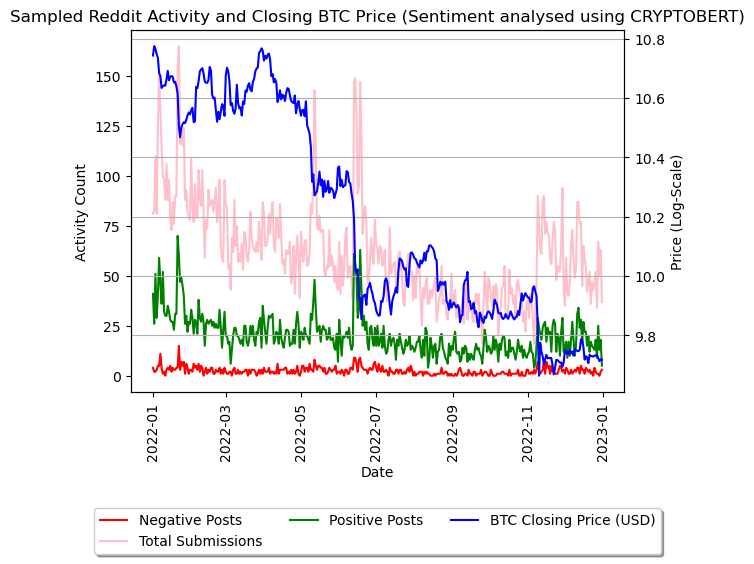

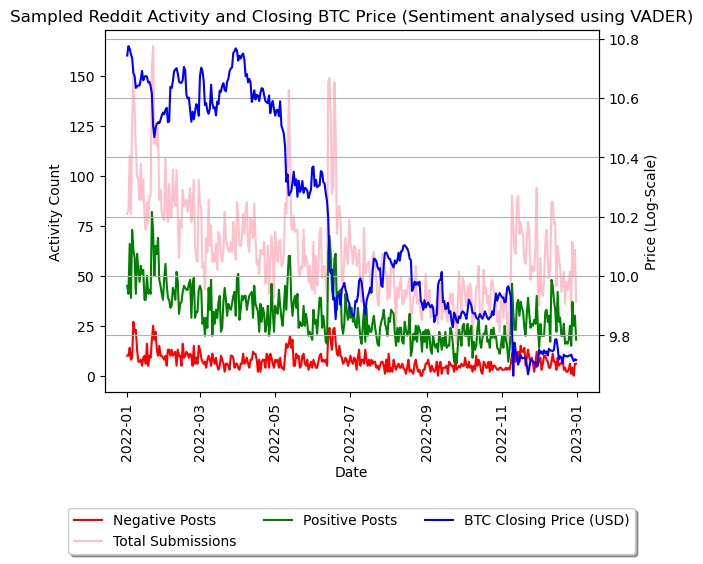

In [30]:
for model in ['CRYPTOBERT','VADER']:
    data1 = np.log(ts_prices_btc['price'])
    data2 = ts_prices_btc[f'{model}_submission_Negative']
    data3 = ts_prices_btc['total_submission']
    data4 = ts_prices_btc[f'{model}_submission_Positive']
    plot_sentiment_price(data1, data2, data3, data4, model=model)

## Ethereum

In [7]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum.csv",index_col='date',parse_dates=['date'])

<AxesSubplot:xlabel='date'>

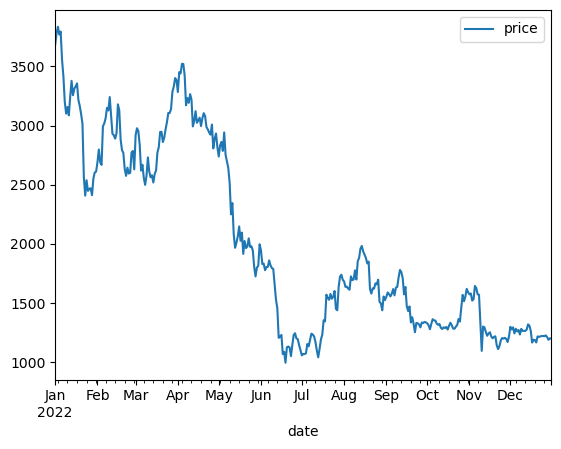

In [8]:
ts_prices_eth.plot()

In [9]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [10]:
for model in ['CRYPTOBERT','VADER']:
    for filetype in ['submission','comment']:
        print(f"{model}_{filetype}_sentiment")
        df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_{filetype}_sentiment.csv",index_col='posted_on',parse_dates=['posted_on'])
        # print(df.columns)
        for col in df.columns[:3]:
            ts_prices_eth[f"{model}_{filetype}_{col}_prop"] = df[col]/df['total_posts']
            ts_prices_eth[f"{model}_{filetype}_{col}"] = df[col]
        ts_prices_eth[f"total_{filetype}"] = df['total_posts']

CRYPTOBERT_submission_sentiment
CRYPTOBERT_comment_sentiment
VADER_submission_sentiment
VADER_comment_sentiment


In [11]:
# Remove Neautral Time Series
for c in ts_prices_eth.columns:
    if 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_eth.drop(c,axis=1,inplace=True)

Dropping column CRYPTOBERT_submission_Neutral_prop
Dropping column CRYPTOBERT_submission_Neutral
Dropping column CRYPTOBERT_comment_Neutral_prop
Dropping column CRYPTOBERT_comment_Neutral
Dropping column VADER_submission_Neutral_prop
Dropping column VADER_submission_Neutral
Dropping column VADER_comment_Neutral_prop
Dropping column VADER_comment_Neutral


In [12]:
eth_z_transformed = pd.DataFrame()
for col in ts_prices_eth.columns:
    eth_z_transformed[col] = rolling_z_score(ts_prices_eth[col],window_size=29)
eth_z_transformed.dropna(inplace=True)
eth_z_transformed.head(5)

,price,CRYPTOBERT_submission_Negative_prop,CRYPTOBERT_submission_Negative,CRYPTOBERT_submission_Positive_prop,CRYPTOBERT_submission_Positive,total_submission,CRYPTOBERT_comment_Negative_prop,CRYPTOBERT_comment_Negative,CRYPTOBERT_comment_Positive_prop,CRYPTOBERT_comment_Positive,total_comment,VADER_submission_Negative_prop,VADER_submission_Negative,VADER_submission_Positive_prop,VADER_submission_Positive,VADER_comment_Negative_prop,VADER_comment_Negative,VADER_comment_Positive_prop,VADER_comment_Positive
date,,,,,,,,,,,,,,,,,,,
2022-01-29,-1.241553,-1.292623,-1.375364,-0.472969,-1.027967,-1.018246,-0.997921,-0.579650,-0.016464,-0.076955,-0.021518,0.087389,-0.469785,0.771261,-0.462508,-0.511421,-0.354359,-0.768053,-0.402445
2022-01-30,-1.054602,-1.444535,-1.442709,-0.024506,-0.377631,-0.500779,1.974089,2.900000,-1.417057,0.822674,2.593259,-1.411881,-1.332778,2.362013,1.630512,2.063829,3.414934,-0.960129,2.098737
2022-01-31,-0.977471,-0.581108,-0.869578,0.408671,-0.777066,-1.307507,2.470403,0.831962,-1.120658,-0.792183,-0.427415,-2.100094,-1.990122,1.089649,-0.476310,1.153709,0.268375,-1.393142,-1.104900
2022-02-01,-0.749206,-0.008963,-0.276684,1.734914,0.463356,-0.766621,-0.210424,-0.770133,0.286864,-0.735213,-1.096587,-0.037492,-0.398820,1.024691,0.143063,-1.439519,-1.301585,0.578314,-0.927454
2022-02-02,-0.441242,0.438193,-0.240289,-1.713504,-2.014797,-1.591848,-1.614743,-1.460079,-1.001856,-1.425855,-1.583210,-1.043839,-1.341692,0.960106,-1.013514,-0.899594,-1.314244,-0.186284,-1.745214


price


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


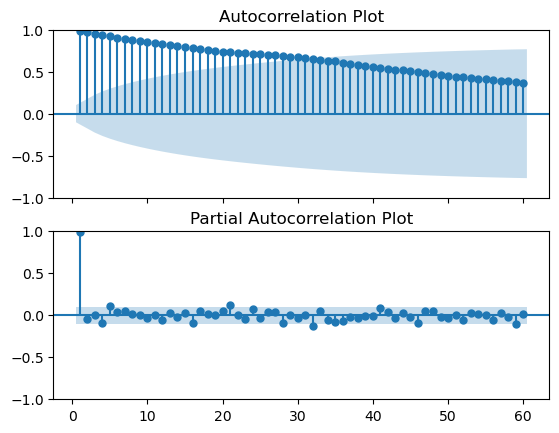

Augmented Dicky Fuller Test
Test Statistic: -3.721832
p-value: 0.0038163
Lag Used: 0
Series is likely stationary
****************************************************************************************************


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


CRYPTOBERT_submission_Negative_prop


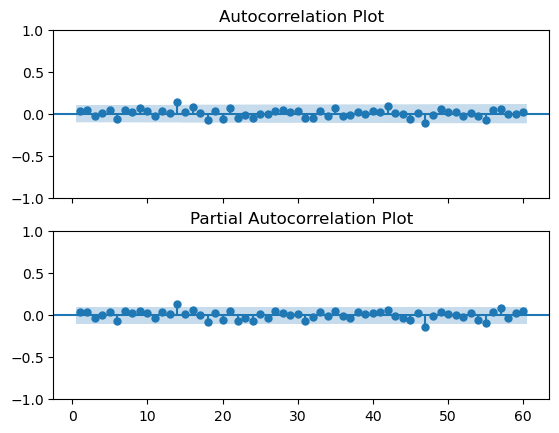

Augmented Dicky Fuller Test
Test Statistic: -17.0074749
p-value: 0.0
Lag Used: 0
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


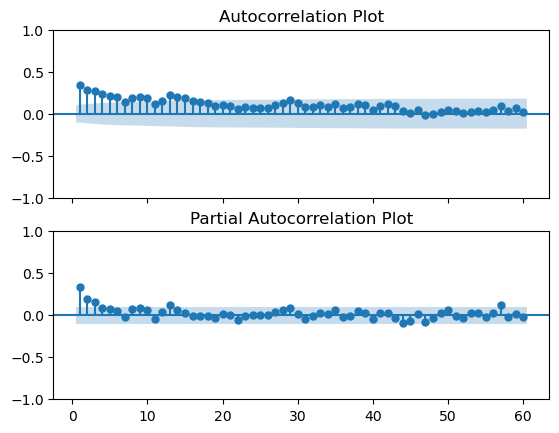

Augmented Dicky Fuller Test
Test Statistic: -11.1558419
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


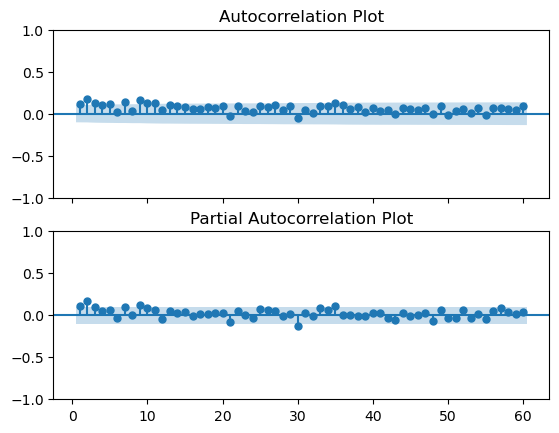

Augmented Dicky Fuller Test
Test Statistic: -11.2194817
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_submission_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


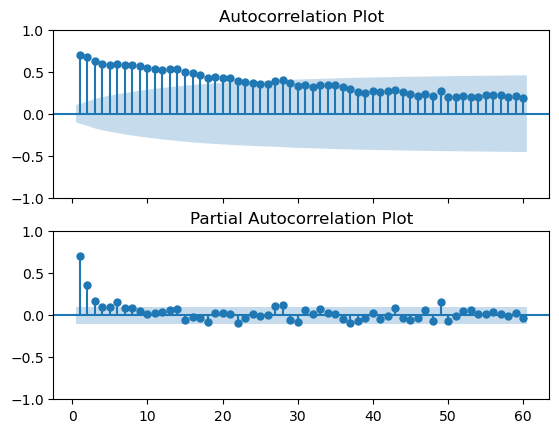

Augmented Dicky Fuller Test
Test Statistic: -9.502587
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
total_submission


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


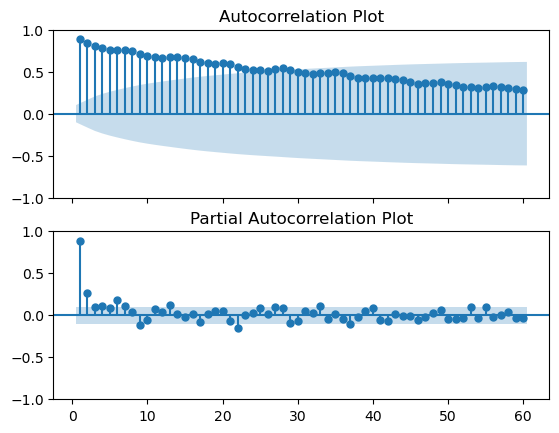

Augmented Dicky Fuller Test
Test Statistic: -5.2107883
p-value: 8.4e-06
Lag Used: 9
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


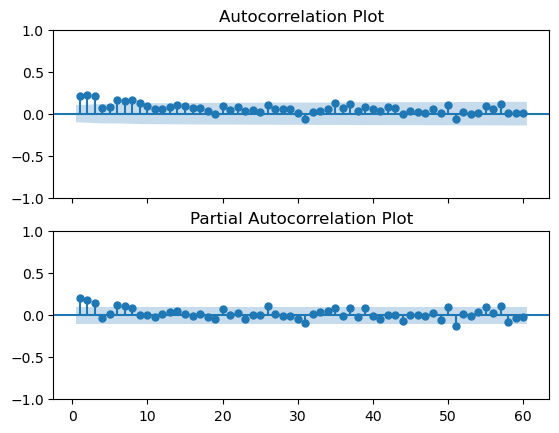

Augmented Dicky Fuller Test
Test Statistic: -5.3882832
p-value: 3.6e-06
Lag Used: 6
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


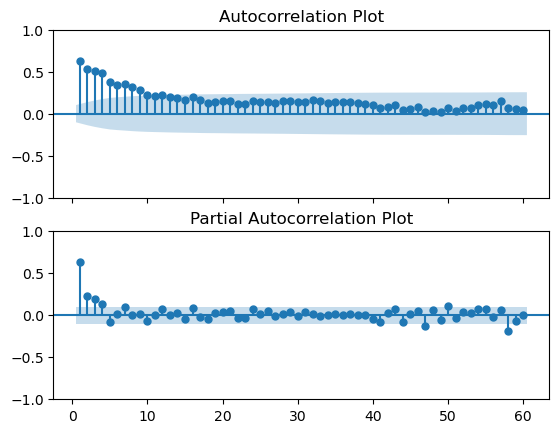

Augmented Dicky Fuller Test
Test Statistic: -7.0649191
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


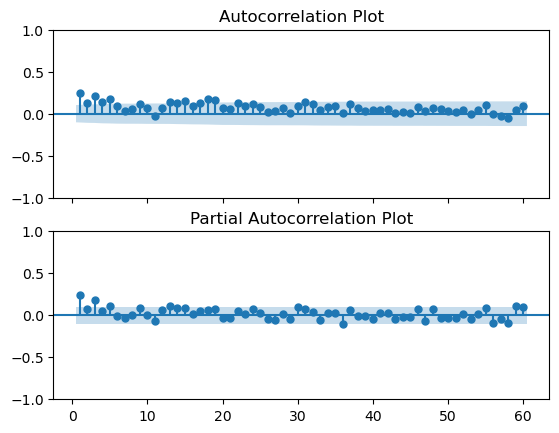

Augmented Dicky Fuller Test
Test Statistic: -15.4978836
p-value: 0.0
Lag Used: 0
Series is likely stationary
****************************************************************************************************
CRYPTOBERT_comment_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


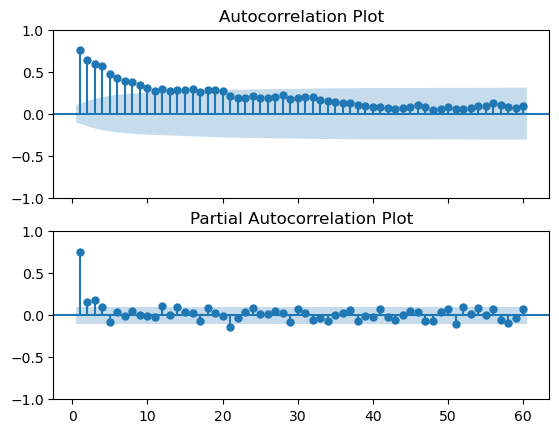

Augmented Dicky Fuller Test
Test Statistic: -6.2695046
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
total_comment


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


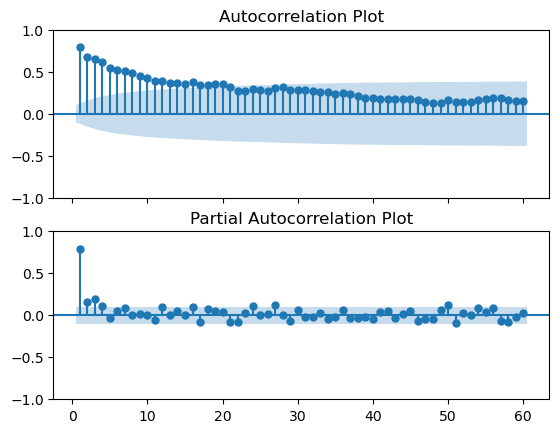

Augmented Dicky Fuller Test
Test Statistic: -6.3916729
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
VADER_submission_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


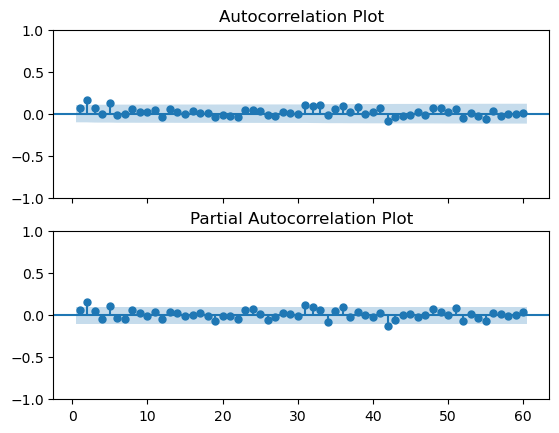

Augmented Dicky Fuller Test
Test Statistic: -11.446246
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


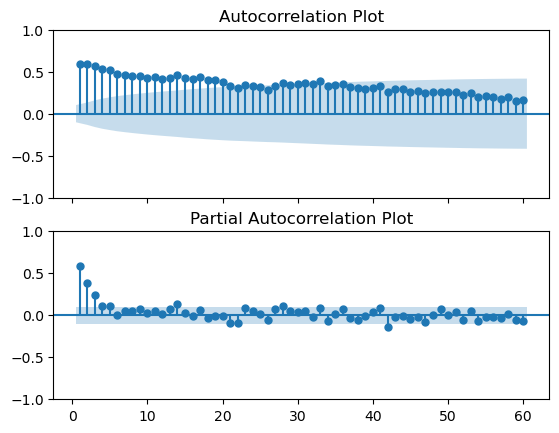

Augmented Dicky Fuller Test
Test Statistic: -9.4369378
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


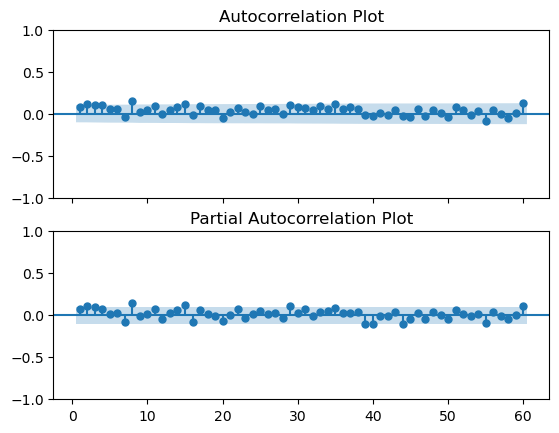

Augmented Dicky Fuller Test
Test Statistic: -11.5873595
p-value: 0.0
Lag Used: 1
Series is likely stationary
****************************************************************************************************
VADER_submission_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


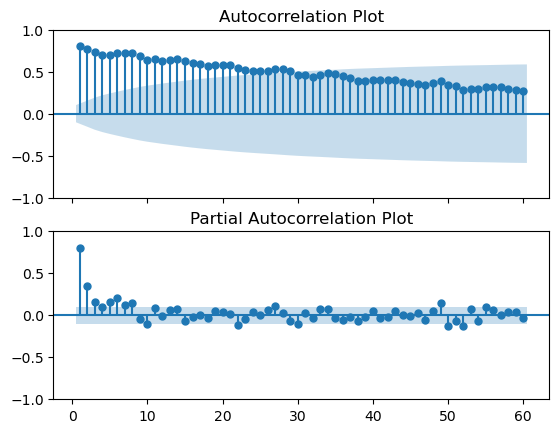

Augmented Dicky Fuller Test
Test Statistic: -5.0455834
p-value: 1.8e-05
Lag Used: 9
Series is likely stationary
****************************************************************************************************
VADER_comment_Negative_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


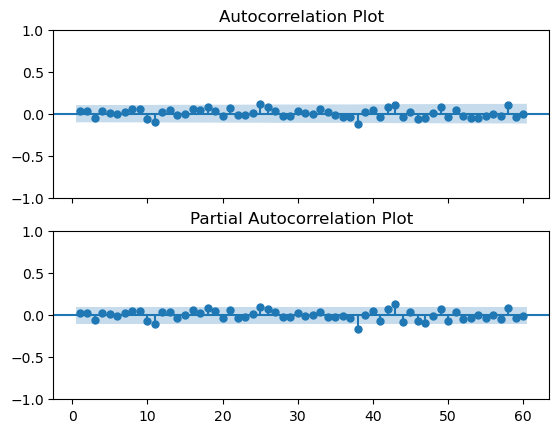

Augmented Dicky Fuller Test
Test Statistic: -17.7880959
p-value: 0.0
Lag Used: 0
Series is likely stationary
****************************************************************************************************
VADER_comment_Negative


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


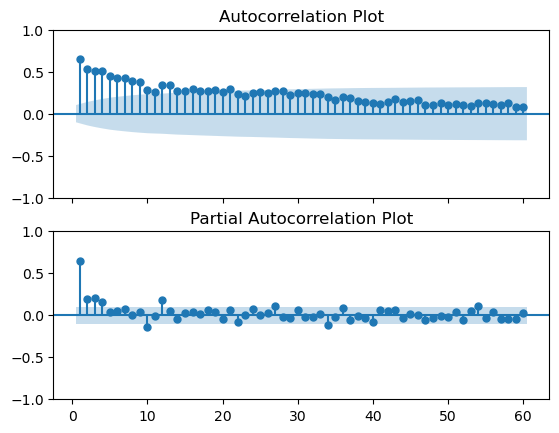

Augmented Dicky Fuller Test
Test Statistic: -6.7623355
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************
VADER_comment_Positive_prop


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


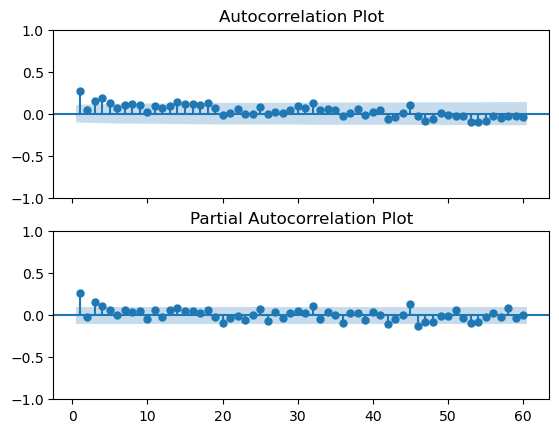

Augmented Dicky Fuller Test
Test Statistic: -15.181989
p-value: 0.0
Lag Used: 0
Series is likely stationary
****************************************************************************************************
VADER_comment_Positive


/Users/nikshubhakumar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


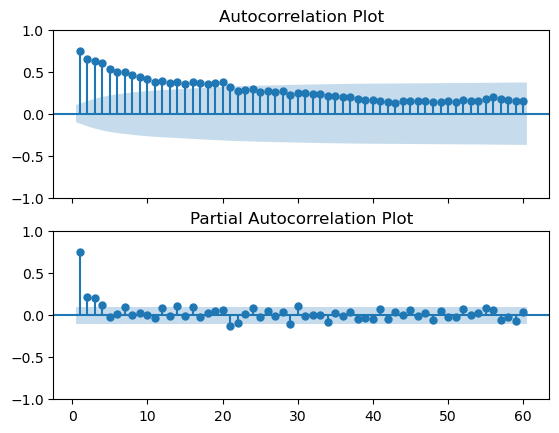

Augmented Dicky Fuller Test
Test Statistic: -6.5194272
p-value: 0.0
Lag Used: 2
Series is likely stationary
****************************************************************************************************


In [22]:
# Checking for Stationarity
for i in range(0,len(eth_z_transformed.columns)):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    ax1, ax2 = axes.flatten()
    print(eth_z_transformed.columns[i])
    plot_acf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    plot_pacf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    plt.show()
    adf_test(eth_z_transformed.iloc[:,i])
    print("*"*100)

Hence, all the time series are now stationary

In [17]:
columns = [] 
for col in ts_prices_eth.columns[1:]:
    for i in range(1,15):
        columns.append(f'{col}_{i}_lag')
print(columns)
gc_results = pd.DataFrame(index=columns)

['CRYPTOBERT_submission_Negative_prop_1_lag', 'CRYPTOBERT_submission_Negative_prop_2_lag', 'CRYPTOBERT_submission_Negative_prop_3_lag', 'CRYPTOBERT_submission_Negative_prop_4_lag', 'CRYPTOBERT_submission_Negative_prop_5_lag', 'CRYPTOBERT_submission_Negative_prop_6_lag', 'CRYPTOBERT_submission_Negative_prop_7_lag', 'CRYPTOBERT_submission_Negative_prop_8_lag', 'CRYPTOBERT_submission_Negative_prop_9_lag', 'CRYPTOBERT_submission_Negative_prop_10_lag', 'CRYPTOBERT_submission_Negative_prop_11_lag', 'CRYPTOBERT_submission_Negative_prop_12_lag', 'CRYPTOBERT_submission_Negative_prop_13_lag', 'CRYPTOBERT_submission_Negative_prop_14_lag', 'CRYPTOBERT_submission_Negative_1_lag', 'CRYPTOBERT_submission_Negative_2_lag', 'CRYPTOBERT_submission_Negative_3_lag', 'CRYPTOBERT_submission_Negative_4_lag', 'CRYPTOBERT_submission_Negative_5_lag', 'CRYPTOBERT_submission_Negative_6_lag', 'CRYPTOBERT_submission_Negative_7_lag', 'CRYPTOBERT_submission_Negative_8_lag', 'CRYPTOBERT_submission_Negative_9_lag', 'CRY

In [24]:
for i in range(1,len(eth_z_transformed.columns)):
    # print(btc_z_transformed.columns[i])
    sig_p_values = extract_significant_granger_causality(eth_z_transformed.iloc[:,[0,i]], max_lag=14)
    p_values = extract_p_value(eth_z_transformed.iloc[:,[0,i]], max_lag=14)
    for p,v in p_values.items():
            gc_results.loc[f'{eth_z_transformed.columns[i]}_{p}_lag','value'] = v
    if sig_p_values:
        print(f'\n{eth_z_transformed.columns[i]}:')
        for p,v in sig_p_values.items():
            print(f"is significant at 0.05 value with p-value of {v} at {p} lag(s)")
    # for p,v in p_values.items():
    #     gc_results.loc[f'{btc_z_transformed.columns[i]}_{p}_lag',k] = v
    # print("*"*20)


CRYPTOBERT_submission_Negative_prop:
is significant at 0.05 value with p-value of 0.010823275874755461 at 1 lag(s)
is significant at 0.05 value with p-value of 0.03788086963578885 at 2 lag(s)

CRYPTOBERT_submission_Negative:
is significant at 0.05 value with p-value of 0.0007348684778849176 at 1 lag(s)
is significant at 0.05 value with p-value of 0.0032948138828409615 at 2 lag(s)
is significant at 0.05 value with p-value of 0.009924147337770155 at 3 lag(s)
is significant at 0.05 value with p-value of 0.039030251924854265 at 4 lag(s)

total_submission:
is significant at 0.05 value with p-value of 0.012745384237617488 at 2 lag(s)
is significant at 0.05 value with p-value of 0.03481703256571155 at 3 lag(s)

CRYPTOBERT_comment_Negative_prop:
is significant at 0.05 value with p-value of 0.043855646965852924 at 1 lag(s)

CRYPTOBERT_comment_Negative:
is significant at 0.05 value with p-value of 0.0016935825002871963 at 1 lag(s)
is significant at 0.05 value with p-value of 0.00628293769946893

In [26]:
gc_results.to_csv(f"Data/Results/{crypto}/p_values.csv")

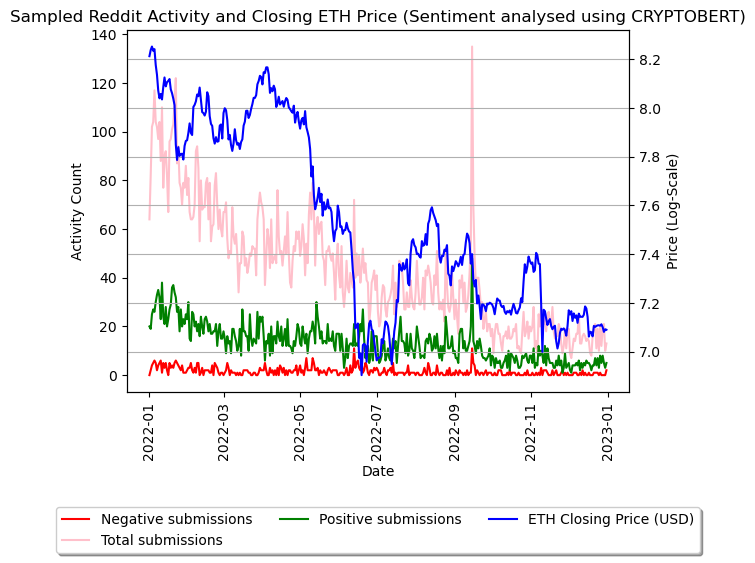

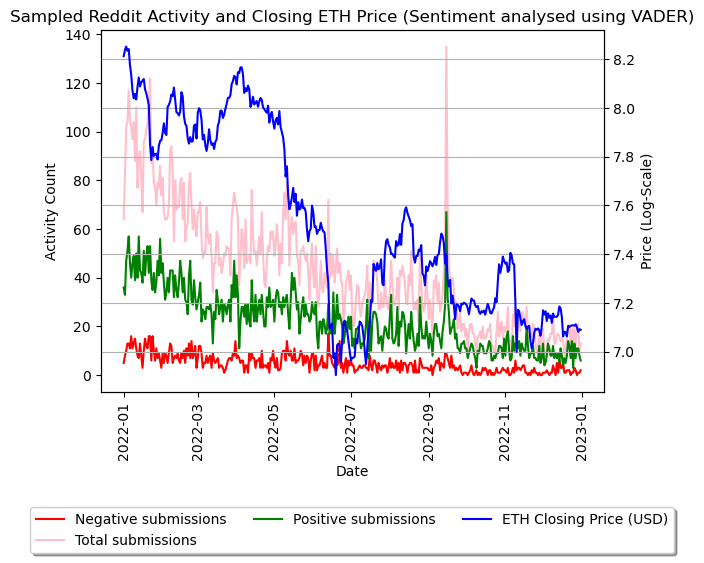

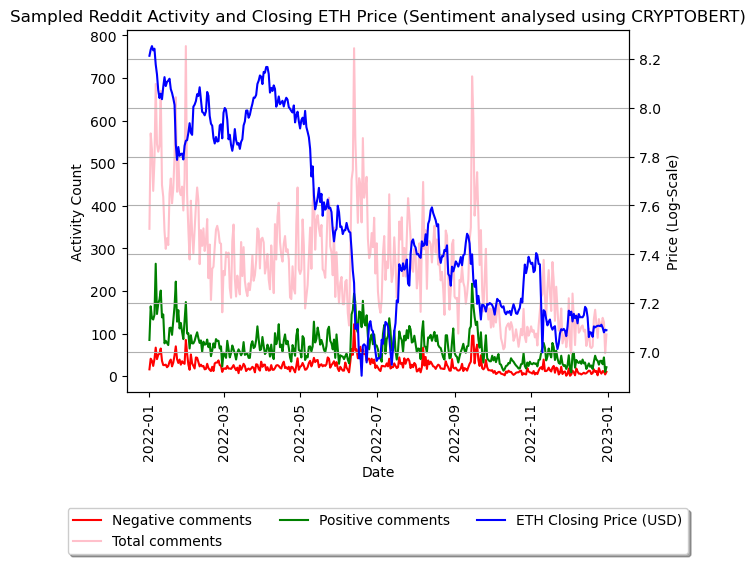

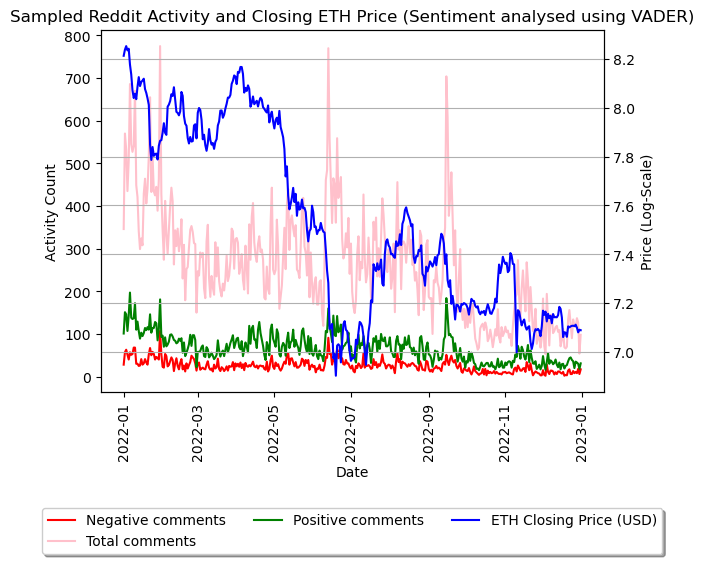

In [36]:
for filetype in ['submission','comment']:
    for model in ['CRYPTOBERT','VADER']:
        data1 = np.log(ts_prices_eth['price'])
        data2 = ts_prices_eth[f'{model}_{filetype}_Negative']
        data3 = ts_prices_eth[f'total_{filetype}']
        data4 = ts_prices_eth[f'{model}_{filetype}_Positive']
        plot_sentiment_price(data1, data2, data3, data4, model=model, crypto='ETH', filetype=filetype)